In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

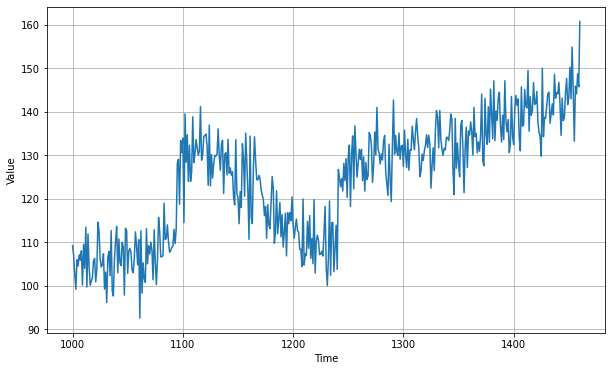

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


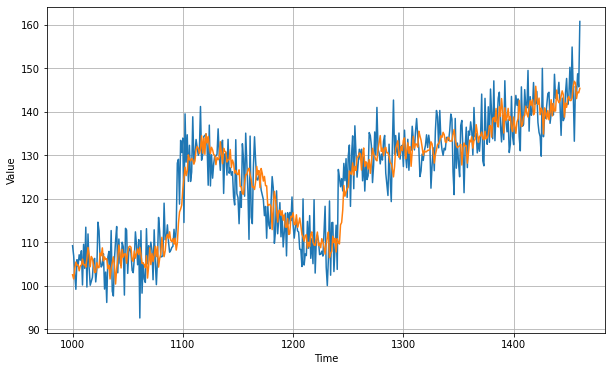

In [6]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.55692

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

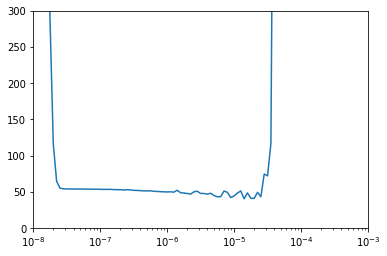

In [9]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [10]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

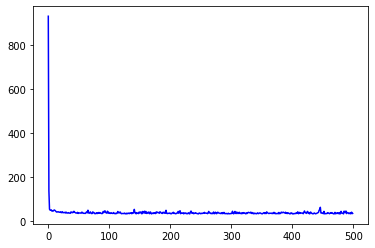

In [11]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[50.01254653930664, 47.86581039428711, 44.96072769165039, 42.12833786010742, 40.28450012207031, 41.04663848876953, 42.31673812866211, 41.139434814453125, 39.705360412597656, 40.28036880493164, 41.934593200683594, 38.03941345214844, 38.33262252807617, 42.34892654418945, 37.70274353027344, 38.33659362792969, 38.65460968017578, 38.885032653808594, 36.54322814941406, 40.62456130981445, 36.690799713134766, 36.60974884033203, 35.903446197509766, 37.958709716796875, 36.6169548034668, 36.05842590332031, 35.01845169067383, 40.89866638183594, 38.29050064086914, 39.914981842041016, 37.75294494628906, 39.919639587402344, 44.14675521850586, 39.89823913574219, 38.65962600708008, 36.67070770263672, 35.7376708984375, 37.18422317504883, 39.27754211425781, 34.30644226074219, 36.769813537597656, 36.273624420166016, 36.1649055480957, 36.223819732666016, 35.75283432006836, 40.19801712036133, 38.516605377197266, 34.86376190185547, 35.230899810791016, 35.070770263671875, 35.22603225708008, 34.564208984375, 3

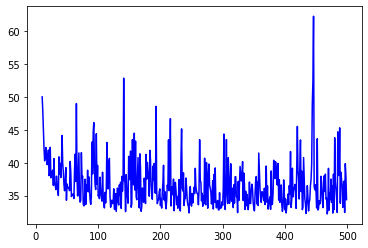

In [12]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

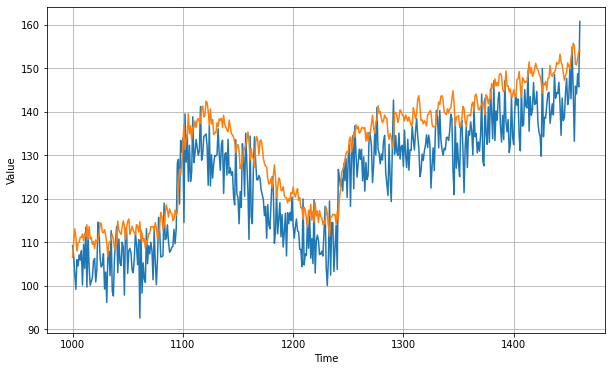

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.5269647